# STA 141B Project Group 12

## Introduction

The main point of this project will be to see what factors affect a game's ratings or "how good" a game is. Some possible factors include price, popularity / culture, gameplay, etc...
#Later specify which factors in specific
#Should also specify the broader significance and impact of this question

## Methods

In [2]:
import requests
import pandas as pd
import requests_cache
import time
import lxml.html as lx
import re
#requests_cache.install_cache("Final_Project")

In [4]:
url = 'https://www.cheapshark.com/api/1.0/deals' # Testing environment

#


In [7]:
test_set = pd.DataFrame() # Testing 
for i in range(1, 2):
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i,
    'AAA' : 1
    })

    data = result.json()
    data = pd.DataFrame(data)

    test_set = pd.concat([test_set, data], ignore_index=True)

    time.sleep(2)

remove later (rel code below)

In [5]:
full_set = pd.DataFrame() # It's named that way but is actually just used for making the indie set
for i in range(1, 51):
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i
    })

    data = result.json()
    data = pd.DataFrame(data)

    full_set = pd.concat([full_set, data], ignore_index=True)

    time.sleep(2)

full_set = full_set[["title", "steamAppID", "releaseDate", "normalPrice", "metacriticScore", "steamRatingText", "steamRatingPercent"]]

In [11]:
aaa_set = pd.DataFrame()
for i in range(1, 46): # Putting in AAA parameter limits the max pages down to 50 for some reason
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i,
    'AAA' : 1
    })

    data = result.json()
    data = pd.DataFrame(data)

    aaa_set = pd.concat([aaa_set, data], ignore_index=True)

    time.sleep(2)

aaa_set = aaa_set[["title", "steamAppID", "releaseDate", "normalPrice", "metacriticScore", "steamRatingText", "steamRatingPercent"]]

In [12]:
aaa_set["normalPrice"] = aaa_set["normalPrice"].astype(float)
aaa_set["metacriticScore"] = aaa_set["metacriticScore"].astype(int)
aaa_set["steamRatingPercent"] = aaa_set["steamRatingPercent"].astype(int)
aaa_set = aaa_set[aaa_set["metacriticScore"] > 0]
aaa_set = aaa_set[aaa_set["normalPrice"] < 70] # API has some errors address this in markdown

In [6]:
full_set["normalPrice"] = full_set["normalPrice"].astype(float)
full_set["metacriticScore"] = full_set["metacriticScore"].astype(int)
full_set["steamRatingPercent"] = full_set["steamRatingPercent"].astype(int)
#type(full_set["normalPrice"][1])

In [7]:
#aaa_set = full_set[full_set["normalPrice"] >= 29]
indie_set = full_set[full_set["normalPrice"] < 29] # No way to parse for normal price on the API, alternative method is this
indie_set = indie_set[indie_set["metacriticScore"] > 0] # To account for missing metacritic

In [ ]:
#html_page.xpath('//a[@class="tab_item_overlay"]/@href')[0]

In [30]:
### STEAM SCRAPING WORK DO NIOT RUN
steam_base = 'https://store.steampowered.com/search/?term='
steam = requests.get(steam_base + "Modern+Warfare+3")


html = lx.fromstring(steam.text)
game_store = html.xpath('//div[@id="search_resultsRows"]//a/@href')[0]
steam_page = requests.get(game_store)
html_page = lx.fromstring(steam_page.text)
#html_page.xpath('//a[@class="tab_item_overlay"]/@href')[0]
dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
pub = html_page.xpath('//div[@class="summary column"]//a/text()')
pub = str(pub[len(pub) - 1])


In [154]:
search_title = [title.replace(" ", "+").replace("!", "").replace("?", "") for title in indie_set["title"]] # DO NOT RUN
#RUN CODE BELOW

In [8]:
def get_authors(search_title):
    steam_base = 'https://store.steampowered.com/search/?term=' #BACKUP
    developers = []
    publishers = []

    for titles in search_title:
        steam = requests.get(steam_base + titles)
        html = lx.fromstring(steam.text)
        try: # Cheapshark API sometimes makes errors. There is no way to automatically fix the query
            # Instead, just set them to broken
            game_store = html.xpath('//div[@id="search_resultsRows"]//a/@href')[0]
        except:
            developers.append("BROKEN_ERROR")
            publishers.append("BROKEN_ERROR")
            continue

        steam_page = requests.get(game_store)
        html_page = lx.fromstring(steam_page.text)
        try:
            dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
            pub = html_page.xpath('//div[@class="summary column"]//a/text()')
            pub = str(pub[len(pub) - 1])
        except: # In the event it leads to a bundle for some reason
            try: 
                game_store = html_page.xpath('//a[@class="tab_item_overlay"]/@href')[0]
                steam_page = requests.get(game_store)
                html_page = lx.fromstring(steam_page.text)
                dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
                pub = html_page.xpath('//div[@class="summary column"]//a/text()')
                pub = str(pub[len(pub) - 1])
            except: # IN THE EVENT IT WAS DUE TO THERE BEING NO DEVELOPER
                game_store = html.xpath('//div[@id="search_resultsRows"]//a/@href')[0]
                steam_page = requests.get(game_store)
                html_page = lx.fromstring(steam_page.text)

                try:
                    dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
                    #pub = html_page.xpath('//div[@class="summary column"]//a/text()')
                    #pub = str(pub[len(pub) - 1])
                except: 
                    try:
                        dev = "BROKEN_ERROR"
                        pub = html_page.xpath('//div[@class="summary column"]//a/text()')
                        pub = str(pub[len(pub) - 1])
                    except:
                        developers.append("BROKEN_ERROR")
                        publishers.append("BROKEN_ERROR")
                        continue


        developers.append(dev)
        publishers.append(pub)
        
        #time.sleep(1)
    authors = pd.DataFrame({'developers' : developers, 'publishers' : publishers})
    return authors

In [45]:
steam_base = 'https://store.steampowered.com/search/?term=' #BACKUP DONT RUN
developers = []
publishers = []

for titles in search_title:
    steam = requests.get(steam_base + titles)
    html = lx.fromstring(steam.text)
    try: # Cheapshark API sometimes makes errors. There is no way to automatically fix the query
        # Instead, just set them to broken
        game_store = html.xpath('//div[@id="search_resultsRows"]//a/@href')[0]
    except:
        developers.append("BROKEN_ERROR")
        publishers.append("BROKEN_ERROR")
        continue

    steam_page = requests.get(game_store)
    html_page = lx.fromstring(steam_page.text)
    try:
        dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
        pub = html_page.xpath('//div[@class="summary column"]//a/text()')
        pub = str(pub[len(pub) - 1])
    except: # In the event it leads to a bundle for some reason
        try: 
            game_store = html_page.xpath('//a[@class="tab_item_overlay"]/@href')[0]
            steam_page = requests.get(game_store)
            html_page = lx.fromstring(steam_page.text)
            dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
            pub = html_page.xpath('//div[@class="summary column"]//a/text()')
            pub = str(pub[len(pub) - 1])
        except: # IN THE EVENT IT WAS DUE TO THERE BEING NO DEVELOPER
            game_store = html.xpath('//div[@id="search_resultsRows"]//a/@href')[0]
            steam_page = requests.get(game_store)
            html_page = lx.fromstring(steam_page.text)

            try:
                dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
                #pub = html_page.xpath('//div[@class="summary column"]//a/text()')
                #pub = str(pub[len(pub) - 1])
            except: 
                try:
                    dev = "BROKEN_ERROR"
                    pub = html_page.xpath('//div[@class="summary column"]//a/text()')
                    pub = str(pub[len(pub) - 1])
                except:
                    developers.append("BROKEN_ERROR")
                    publishers.append("BROKEN_ERROR")
                    continue


    developers.append(dev)
    publishers.append(pub)
    
    #time.sleep(1)

In [44]:
search_title = [title.replace(" ", "+").replace("!", "").replace("?", "") for title in indie_set["title"]][0: 100]


In [9]:
search_title = [title.replace(" ", "+").replace("!", "").replace("?", "") for title in indie_set["title"]]
indie_authors = get_authors(search_title) # Function do not run if data is already available

In [10]:
indie_set = indie_set.reset_index(drop = True)
indie_set = pd.concat([indie_set, indie_authors], axis = 1)

In [13]:
search_title = [title.replace(" ", "+").replace("!", "").replace("?", "") for title in aaa_set["title"]] #AAA
aaa_authors = get_authors(search_title)

In [14]:
aaa_set = aaa_set.reset_index(drop = True)
aaa_set = pd.concat([aaa_set, aaa_authors], axis = 1)

In [17]:
aaa_set.to_csv('aaa_set.csv', index = False)
indie_set.to_csv('indie_set.csv', index= False)

### JUDAH SECTION

#### Conversion of datetime from unix to YY-MM-DD

In [15]:
full_set['releaseDate'] = pd.to_datetime(full_set['releaseDate'], unit='s').dt.date
aaa_set['releaseDate'] = pd.to_datetime(aaa_set['releaseDate'], unit='s').dt.date
indie_set['releaseDate'] = pd.to_datetime(indie_set['releaseDate'], unit='s').dt.date

In [12]:
full_set.head()

,title,gameID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent
0,Stealth Bastard Deluxe,93923,2012-11-28,9.99,80,Very Positive,88
1,Prince of Persia: The Sands of Time,278,2003-12-02,9.99,89,Very Positive,85
2,Raw Data,154911,2017-10-02,39.99,87,Very Positive,82
3,GUILTY GEAR Xrd -SIGN-,147415,2015-12-09,29.99,84,Very Positive,91
4,BioShock Infinite,93503,2013-03-25,29.99,94,Very Positive,93


In [13]:
aaa_set.head()

,title,gameID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent
0,Rise of the Tomb Raider,145517,2016-01-28,29.99,86,Very Positive,94
1,GOD EATER 2 Rage Burst,155097,2016-08-29,49.99,73,Very Positive,80
2,Yooka-Laylee,164041,2017-04-05,49.99,73,Mostly Positive,78
3,Dragons Dogma: Dark Arisen,146236,2016-01-15,29.99,81,Very Positive,89
4,The Sinking City,201604,2019-06-27,39.99,71,Mostly Positive,73


In [14]:
indie_set.head()

,title,gameID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent
0,Stealth Bastard Deluxe,93923,2012-11-28,9.99,80,Very Positive,88
1,Prince of Persia: The Sands of Time,278,2003-12-02,9.99,89,Very Positive,85
6,Crayon Physics Deluxe,709,2009-01-07,19.99,79,Very Positive,90
7,Amnesia: The Dark Descent,86,2010-09-08,19.99,85,Overwhelmingly Positive,95
8,Company of Heroes,117,2006-09-13,19.99,93,Very Positive,94


#### Plots

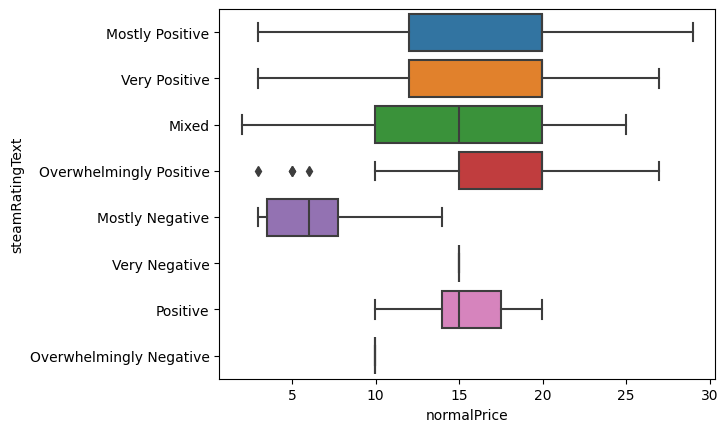

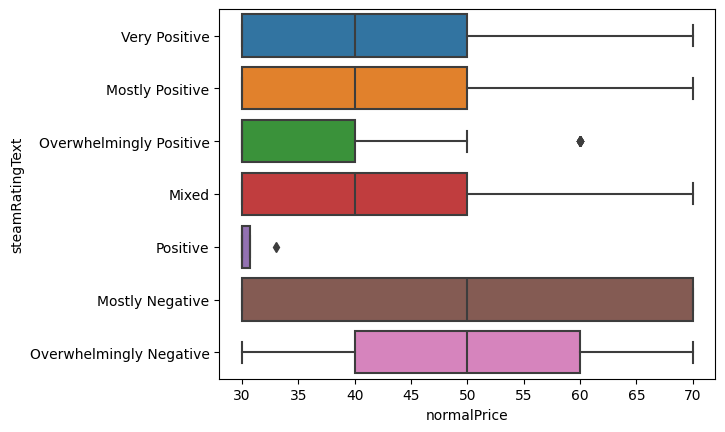

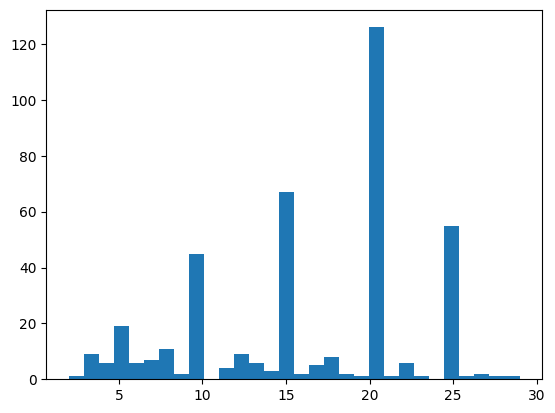

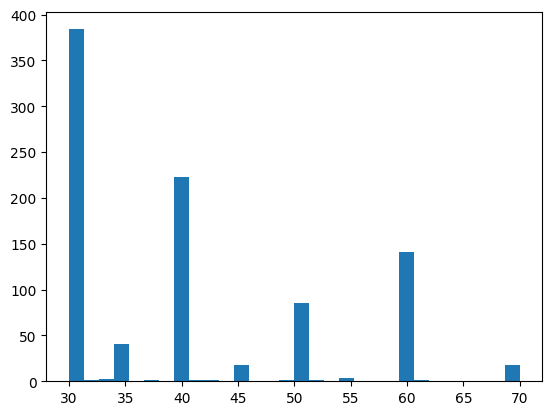

In [16]:
#Currently how it goes is :
#Check steamRatingText against price

#MAKE NOTES ON WHAT EACH PLOT MEANS, maybe make a time series or heatmap for dates etc
#ALSO put the plots on the same grid to make them easily comparable. or put them on the same graph with different colors
#In this one, it's lowk opposite of Shizhe chen. they're grading based on complexity.
#we need more dimensions for complexity

#Currently I'm checking
# - steamratingpercent/metacriticscore against normal price (via boxplots, histogrmas)
# - steamratingpercent/metacriticscore against release data
# - normalPrice against release date... inflation?
#so we're checking generally what factors affect a game's rating. the issue is this doesn't provide much factors except for the normalprice
#Can use youtube to check popularity
import matplotlib.pyplot as plt
import seaborn as sns

#Basic boxplot: Rating texts on normal price, for indie
sns.boxplot(x='normalPrice', y='steamRatingText', data=indie_set)
plt.show()

#Basic boxplot: Rating texts on normal price, for aaa
sns.boxplot(x='normalPrice', y='steamRatingText', data=aaa_set)
plt.show()
#fix idk why  overwhelmingly negative and positive are merged

#Find also just overall distribution of prices... then maybe for boxplots do percents? Right because you see the reviews are mainly at 
#    $15 but maybe that's because you just have a lot of games at $15. In which case, you'd wanna keep that in mind. Idk if you can
#    make an edit that'd change things though... mainly for indie

#PUT MORE LABELS FOR HISTOGRAMS
plt.hist(indie_set['normalPrice'], bins=30)
plt.show()

plt.hist(aaa_set['normalPrice'], bins=30)
plt.show()

#SEGMENTED HISTOGRAM for prices and stuff

#Try your own natural language processing to check ratings
#Check youtube something, maybe it affects something
#For complexity, I also want to try web scraping 

Testing environment

In [2]:
#test = result.json()
#print(result.headers['X-Total-Page-Count']) # Important if we want to parse through all pages
#print(result.url)
#
#test = pd.DataFrame(test)
#
#header = result.headers

### Zhanyi Section

In [3]:
import pandas as pd
import requests

def get_reviews(game_id,csv_file):
    # Define the URL for the OpenCritic API, using the game_id parameter
    url = f"https://opencritic-api.p.rapidapi.com/reviews/game/{game_id}"
    
    # Set up the headers for the API request
    headers = {
        "X-RapidAPI-Key": "61206e4cddmshb83e09e46beb28ep1c0a4cjsn8e27fb46a529",
        "X-RapidAPI-Host": "opencritic-api.p.rapidapi.com"
    }
    
    # Make a GET request to the OpenCritic API
    response = requests.get(url, headers=headers)
    
    # Check if the response status code is 200 (OK).
    if response.status_code != 200:
        print(f"Failed to fetch data for game ID {game_id}")
        return

    # Extract data
    data = response.json()
    df = pd.DataFrame(data)
    
    df = pd.DataFrame(data)[['game', 'score','Outlet','Platforms'] ]
    
    df['platform_names'] = df['Platforms'].apply(lambda x: ', '.join([platform['name'] for platform in x if 'name' in platform]))
    
    df['game_name'] = df['game'].apply(lambda x: x['name'])
    
    df['outlet_name'] = df['Outlet'].apply(lambda x: x['name'])
    
    df = df.dropna(subset=['score'])
    df = df[df['score'] != 0]
    df = df[df['platform_names'].str.len() > 0]
    df = df.drop_duplicates(subset='outlet_name')
    df = df.drop_duplicates(subset='platform_names')
    
    # Combine score and platform into a single string
    df['score_outlet'] = df.apply(lambda x: f"Score: {x['score']}, Reviewr: {x['outlet_name']}", axis=1)

    # Pivot the DataFrame
    pivot_df = df.pivot(index='game_name', columns='platform_names', values='score_outlet')
 
    # Dropcolumns to match your data
    if 'PlayStation Vita' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['PlayStation Vita'])
    
    # Drop the 'Nintendo Switch' column
    if 'Nintendo Switch' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['Nintendo Switch'])
        
    if 'PlayStation 4, Xbox One' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['PlayStation 4, Xbox One']) 
        
    if 'PlayStation 4, PC' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['PlayStation 4, PC'])   
        
    if 'Nintendo Switch, PC, PlayStation 4' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['Nintendo Switch, PC, PlayStation 4'])     
    
    # Rename the 'PS5' column to 'PlayStation'
    if 'PlayStation 5' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'PlayStation 5': 'PlayStation'})
      
    if 'Xbox Series X/S' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'Xbox Series X/S': 'Xbox'})
        
    if 'Xbox One' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'Xbox One': 'Xbox'})
        
    if 'PlayStation 4' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'PlayStation 4': 'PlayStation'})
        
    if 'PlayStation 4, Xbox One, PC' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'PlayStation 4, Xbox One, PC': 'Xbox'})
    
    if 'PC, PlayStation 4, Xbox One' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'PC, PlayStation 4, Xbox One': 'Xbox'})
        
    if 'Xbox One, PlayStation 4, PC' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'Xbox One, PlayStation 4, PC': 'Xbox'})
    
    if 'Xbox Series X/S, PlayStation 5, PC' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'Xbox Series X/S, PlayStation 5, PC': 'Xbox'})
        
    # Drop one of the duplicate 'Xbox' columns
    # Assuming want to keep the first 'Xbox' column and drop the second
    pivot_df = pivot_df.loc[:, ~pivot_df.columns.duplicated()]
    
    pivot_df = pivot_df[['PC','PlayStation','Xbox']]

      # Append to the existing CSV file, create if doesn't exist

    pivot_df.to_csv(csv_file, mode='a', header=not pd.io.common.file_exists(csv_file))  


In [4]:
# Sample 10 AAA
get_reviews(463, 'tem_AAA.csv') # The Witcher 3
get_reviews(12090, 'tem_AAA.csv') # Elden Ring
get_reviews(15855, 'tem_AAA.csv') # Naruto Strom Connection
get_reviews(2851, 'tem_AAA.csv') # The Elder Scrolls V
get_reviews(15847, 'tem_AAA.csv') # Persona 5 Tactica
get_reviews(165, 'tem_AAA.csv') # Assassin's Creed Unity
get_reviews(163, 'tem_AAA.csv') # GTA V
get_reviews(1384, 'tem_AAA.csv') # Devil May Cry 4: SE
get_reviews(1520, 'tem_AAA.csv') # Dark Souls 3
get_reviews(8525, 'tem_AAA.csv') # Cyberpunk 2077

In [5]:
# Sample 10 indie
get_reviews(2848, 'tem_indie.csv') # INSIDE
get_reviews(33, 'tem_indie.csv') # Shovel Knight
get_reviews(2242, 'tem_indie.csv') # Stardew Valley
get_reviews(6386, 'tem_indie.csv') # Dead Cells
get_reviews(3046, 'tem_indie.csv') # Overcooked
get_reviews(6225, 'tem_indie.csv') # Overcooked 2
get_reviews(48, 'tem_indie.csv') # Bastion
get_reviews(1558, 'tem_indie.csv') # Hyper Light Drifter
get_reviews(11608, 'tem_indie.csv') # Doki Doki Literature Club
get_reviews(12163, 'tem_indie.csv') # Inscryption 

In [6]:
file_path = 'C:/Users/nasqi/Final141B/STA-141B-Project/tem_AAA.csv'
AAA_df = pd.read_csv(file_path)

In [7]:
AAA_df.head()

,game_name,PC,PlayStation,Xbox
0,The Witcher 3: Wild Hunt,"Score: 92.0, Reviewr: PC Gamer","Score: 100.0, Reviewr: Eurogamer","Score: 93.0, Reviewr: IGN"
1,Elden Ring,"Score: 90.0, Reviewr: PC Gamer","Score: 100.0, Reviewr: IGN Spain","Score: 90.0, Reviewr: IGN Middle East"
2,Naruto X Boruto Ultimate Ninja Storm Connections,"Score: 70, Reviewr: SpaceNerd.it","Score: 60, Reviewr: GamingTrend","Score: 69, Reviewr: Bazimag"
3,The Elder Scrolls V: Skyrim - Special Edition,"Score: 70.0, Reviewr: Areajugones","Score: 80.0, Reviewr: Metro GameCentral","Score: 80.0, Reviewr: USgamer"
4,Persona 5 Tactica,"Score: 60.0, Reviewr: VideoGamer","Score: 90.0, Reviewr: NookGaming","Score: 70.0, Reviewr: Shacknews"


In [3]:
path = 'C:/Users/nasqi/Final141B/STA-141B-Project/tem_indie.csv'
indie_df = pd.read_csv(path)

In [4]:
indie_df.head()

,game_name,PC,PlayStation,Xbox
0,INSIDE,"Score: 76, Reviewr: PC Gamer","Score: 80, Reviewr: Metro GameCentral","Score: 80, Reviewr: Eurogamer"
1,Shovel Knight,"Score: 70, Reviewr: Eurogamer","Score: 90, Reviewr: Attack of the Fanboy","Score: 80, Reviewr: Metro GameCentral"
2,Stardew Valley,"Score: 80.0, Reviewr: PC Gamer","Score: 90.0, Reviewr: TheSixthAxis","Score: 88.0, Reviewr: IGN"
3,Dead Cells,"Score: 90.0, Reviewr: PC Gamer","Score: 80.0, Reviewr: Metro GameCentral","Score: 90.0, Reviewr: IGN Spain"
4,Overcooked,"Score: 86.0, Reviewr: PC Gamer","Score: 80.0, Reviewr: Eurogamer","Score: 83.0, Reviewr: Game Informer"


In [5]:
def get_review_summary(appid):
    url = f"https://store.steampowered.com/appreviews/{appid}?json=1&filter=summary"
    response = requests.get(url)
    data = response.json()

    total_reviews = data['query_summary']['total_reviews']
    positive_reviews = data['query_summary']['total_positive']
    negative_reviews = data['query_summary']['total_negative']

    return total_reviews, positive_reviews, negative_reviews


In [7]:
update_aaa_set = pd.read_csv('C:/Users/nasqi/141B/STA-141B-Project/aaa_set.csv')

In [8]:
update_aaa_set.head()

,title,steamAppID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent,developers,publishers
0,Creed: Rise to Glory,804490,2018-09-25,29.99,84,Very Positive,80,Survios,Survios
1,My Time At Portia,666140,2019-01-15,29.99,73,Very Positive,92,Pathea Games,Focus Entertainment
2,Mr. DRILLER DrillLand,1126750,2020-06-25,29.99,76,Very Positive,82,"INFINITY Co., Ltd.",BANDAI NAMCO Entertainment
3,The Elder Scrolls V: Skyrim VR,611670,2018-04-02,59.99,81,Mostly Positive,74,Bethesda Game Studios,Bethesda Softworks
4,Dying Light,239140,2015-01-27,49.99,75,Overwhelmingly Positive,95,Techland,Techland


In [9]:
# Fetch and store review data
review_data = update_aaa_set['steamAppID'].apply(lambda x: pd.Series(get_review_summary(x)))
review_data.columns = ['total_reviews', 'positive_reviews', 'negative_reviews']
update_aaa_set = pd.concat([update_aaa_set, review_data], axis=1)

# Now df has the total, positive, and negative reviews for each game

In [10]:
update_aaa_set.head()

,title,steamAppID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent,developers,publishers,total_reviews,positive_reviews,negative_reviews
0,Creed: Rise to Glory,804490,2018-09-25,29.99,84,Very Positive,80,Survios,Survios,947,734,213
1,My Time At Portia,666140,2019-01-15,29.99,73,Very Positive,92,Pathea Games,Focus Entertainment,11234,10409,825
2,Mr. DRILLER DrillLand,1126750,2020-06-25,29.99,76,Very Positive,82,"INFINITY Co., Ltd.",BANDAI NAMCO Entertainment,76,66,10
3,The Elder Scrolls V: Skyrim VR,611670,2018-04-02,59.99,81,Mostly Positive,74,Bethesda Game Studios,Bethesda Softworks,6124,4568,1556
4,Dying Light,239140,2015-01-27,49.99,75,Overwhelmingly Positive,95,Techland,Techland,75539,71174,4365


In [11]:
update_indie_set = pd.read_csv('C:/Users/nasqi/141B/STA-141B-Project/indie_set.csv')

In [12]:
update_indie_set.head()

,title,steamAppID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent,developers,publishers
0,Anomaly Defenders,294750,2014-05-29,9.99,70,Mostly Positive,75,11 bit studios,11 bit studios
1,Monster Energy Supercross - The Official Video...,1089830,2020-02-04,24.99,72,Very Positive,88,Milestone S.r.l.,Milestone S.r.l.
2,Legends of Eisenwald,246760,2014-07-21,19.99,71,Mostly Positive,76,Aterdux Entertainment,Aterdux Entertainment
3,SPACECOM,263860,2014-09-17,9.99,68,Mixed,65,Flow Combine,11 bit studios
4,Trials Evolution: Gold Edition,220160,2013-03-21,19.99,85,Mostly Positive,75,Redlynx Ltd,Ubisoft


In [13]:
# Fetch and store review data
review_data = update_indie_set['steamAppID'].apply(lambda x: pd.Series(get_review_summary(x)))
review_data.columns = ['total_reviews', 'positive_reviews', 'negative_reviews']
update_indie_set = pd.concat([update_indie_set, review_data], axis=1)

# Now df has the total, positive, and negative reviews for each game

In [14]:
update_indie_set.head()

,title,steamAppID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent,developers,publishers,total_reviews,positive_reviews,negative_reviews
0,Anomaly Defenders,294750,2014-05-29,9.99,70,Mostly Positive,75,11 bit studios,11 bit studios,145,99,46
1,Monster Energy Supercross - The Official Video...,1089830,2020-02-04,24.99,72,Very Positive,88,Milestone S.r.l.,Milestone S.r.l.,590,512,78
2,Legends of Eisenwald,246760,2014-07-21,19.99,71,Mostly Positive,76,Aterdux Entertainment,Aterdux Entertainment,442,296,146
3,SPACECOM,263860,2014-09-17,9.99,68,Mixed,65,Flow Combine,11 bit studios,85,56,29
4,Trials Evolution: Gold Edition,220160,2013-03-21,19.99,85,Mostly Positive,75,Redlynx Ltd,Ubisoft,1338,970,368


In [21]:
len(update_aaa_set)

923

In [20]:
len(update_indie_set)

407

In [22]:
update_aaa_set.to_csv('update_aaa_set.csv', index=False)
update_indie_set.to_csv('update_indie_set.csv', index=False)

## Results

## Discussion

## Acknowledgements